# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Implementation of Probability Level in ML Model

In this notebook, you will analyse the performance of an ML model after applying a probability level on the predicted output.

The notebook is structured as follows:
1. [Import Libraries and Data](#import)
2. [Set the Probability Level](#probability)
3. [Implement Machine Learning Model with Probability Level](#new_ml)
4. [Conclusion](#conclusion)

<a id='import'></a>
## Import Libraries and Data

You will use the `pandas` and `numpy` library for data storage and manipulation. The `talib` library is used to calculate technical indicator values. To implement the decision tree model, you will import various modules from the `sklearn` library. Finally, you will use the `matplotlib` library for plotting purposes.

You will import the file `sp500_features_Jan_2009_June_2022.csv` which contains the OHLCV data of the SPDR S&P 500 ETF (ticker: SPY) from January 2009 to June 2022, along with the features which were calculated in the `Decision Tree` sections.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For technical indicator values calculation
import talib as ta

# For machine learning model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score

# For splitting the data into train and test
from sklearn.model_selection import train_test_split

# For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Import warnings
import warnings
warnings.simplefilter("ignore")

# Read data file using read_csv method of pandas
spy = pd.read_csv(
    '../data_modules/sp500_features_Jan_2009_June_2022.csv', index_col=0)

# Print the last 5 rows of the SPY ETF with features
spy.tail()

,Open,High,Low,Close,Volume,f_ret_1,f_ret_5,f_ret_10,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle,target
Date,,,,,,,,,,,,,,
2022-06-23,373.384588,375.555631,369.667000,374.792297,79292100,0.009803,0.001300,-0.076667,2.564619,41.207038,1.010850,0.955454,0.983152,0.031794
2022-06-24,378.103436,386.718328,378.073696,386.708405,98050300,0.031794,0.068499,-0.024101,2.528335,49.154390,1.005813,0.925544,0.965679,-0.003820
2022-06-27,387.670022,387.977340,384.091239,385.231293,66009600,-0.003820,0.062128,0.001202,2.428797,48.283114,1.015780,0.946381,0.981080,-0.020433
2022-06-28,386.857107,389.761775,377.240936,377.359894,86548900,-0.020433,0.014877,0.019451,2.539356,43.825114,1.036293,0.972660,1.004477,-0.000814
2022-06-29,377.934904,378.965893,375.149194,377.052582,65676000,-0.000814,0.015892,0.021700,2.432198,43.655642,1.033850,0.982998,1.008424,NaN


In [2]:
# Store the features in a dataframe
X = spy.filter(like='f_')

# Create and store target variable
spy['target'] = spy.Close.pct_change(1).shift(-1)
y = np.where(spy.target > 0, 1, 0)

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)

## Initialise the Decision Tree Model

You will initialise the decision tree classifier model and set the required hyperparameters.

In [3]:
# Initialise and train decision tree classifier model
clf = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=5, random_state=42)
clf = clf.fit(X_train, y_train)

<a id='pred_output'></a>
## Calculate the Probability of Predicted Output

In the previous sections, you had only one predicted output, which was the predicted signal. Apart from predicting the target class, the decision tree gives the probability of occurrence of the target classes as well. Since the decision tree is trained to predict 1 or 0, you will see the probability levels of these two classes. You will use the `predict_proba` method of the `DecisionTreeClassifier` class.

<B>Syntax:</B> `model.predict_proba(input_data)`

`input_data`: Features data

Returns the prediction probabilities for each class of each output.

In [4]:
# Store the predicted output in new column of dataframe
spy['predicted_signal'] = clf.predict(X)

# Store probability of occurrence values in new dataframe
probability = (clf.predict_proba(X))

# Store the probability of occurrence values for each output separately
spy['probability_0'], spy['probability_1'] = probability[:,0], probability[:,1]

# Print the dataframe with probability of occurrence values
spy.filter(like='prob').tail().round(3)

,probability_0,probability_1
Date,,
2022-06-23,0.405,0.595
2022-06-24,0.497,0.503
2022-06-27,0.405,0.595
2022-06-28,0.405,0.595
2022-06-29,0.405,0.595


### How can you interpret this output?

On 23 June 2022, the decision tree model processed the input features and predicted the probability of 0, i.e. the SPY will go down, as 0.405 or 40%. In contrast, the decision tree predicted that the probability that the SPY will go up is 0.595, or approximately 60%. 
Further, if you look at 24 June, the probability of 0, i.e. the SPY will go down is 0.497. And the probability that the SPY will go up is 0.503, which is barely more than the probability of going down. And yet, the decision tree will predict 1 on 24 June, as the probability of 1 is higher than the probability of 0. 

Thus, you should increase the probability level before the decision tree can reach a decision.

### But which is the right probability level?

Let's group the probability levels of 1 in test data on the basis of their probability levels.

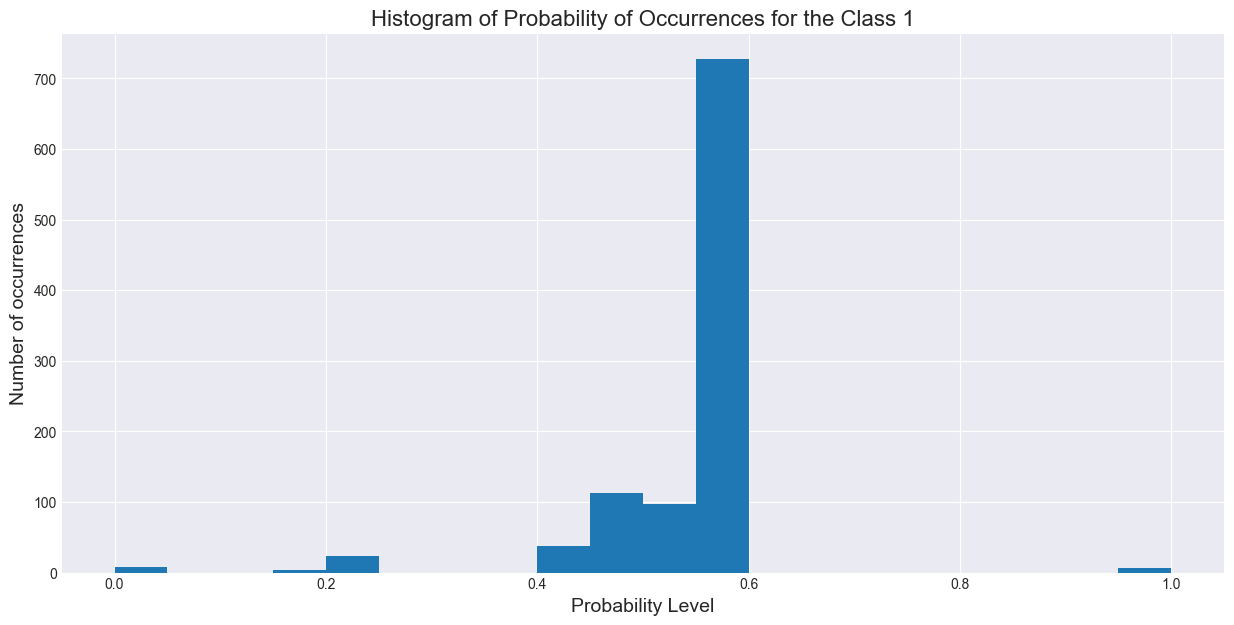

In [5]:
# Declare train and test percentage and split the dataset
split_percentage = 0.7
split = int(split_percentage*len(X))

# Create a new dataframe to store the test data
test_data = spy.iloc[split:]

# Plot the probability values in a histogram
test_data.probability_1.hist(bins=20, figsize = (15,7))
# Set title
plt.title('Histogram of Probability of Occurrences for the Class 1', fontsize=16)
# Set x and y axis labels
plt.xlabel('Probability Level', fontsize=14)
plt.ylabel('Number of occurrences', fontsize=14)
plt.show()

You can see that the majority of times, the decision tree has predicted 1 with the probability of its occurrence as more than 0.55. Thus, when you set the probability level to more than 0.55, you have incorporated most of the instances where the decision tree model has predicted 1.
If you keep the probability higher than 0.6, then you will not get any signals of 1. Keeping the probability level less than 0.55 will mean that you are including all the probability levels of 1.

<a id='probability'></a>
## Set the Probability Level

In this notebook, you will declare a probability level of 0.55 for the decision tree model to predict 1.

### What will happen when you set a probability level?

The decision tree model predicts 0 or 1 based on the input features given. The decision tree model has a choice between two variables only and will choose the variable which has a higher probability of occurrence. For example, a certain combination of features is given and the probability of the occurrence of 1 is 0.53 and 0 is 0.47. The decision tree model will choose 1 as its probability of occurrence is higher. 

If we set the probability level of 0.55, it means that the decision tree model will predict 1 only if its probability of occurrence is more than 0.55. Thus, for the previous example, the decision tree will predict 0, even though the probability of 1 is higher. This is because the probability of 1 is 0.53, which is less than the probability level of 0.55.

In [6]:
# Set a condition that predicted probability of 1 should be more than or equal to 0.55
condition_1 = spy['probability_1'] >= 0.55

# Set a condition that the predicted signal is 1
condition_2 = spy['predicted_signal'] == 1

# Create a trading signal that gives output as 1 only when the predicted probability 
# for 1 is more than or equal to 0.55
spy['predicted_signal_refined'] = np.where(condition_1 & condition_2, 1, 0)


### How well will the strategy perform with the set probability level?

Let's calculate the cumulative returns as well as the Sharpe ratio with the new trading signal.


<a id='new_ml'></a>
## Implement Machine Learning Model with Probability Threshold

You will use the modified trading signals which were generated and stored in the `predicted_signal_refined` column of the `spy` dataframe. 

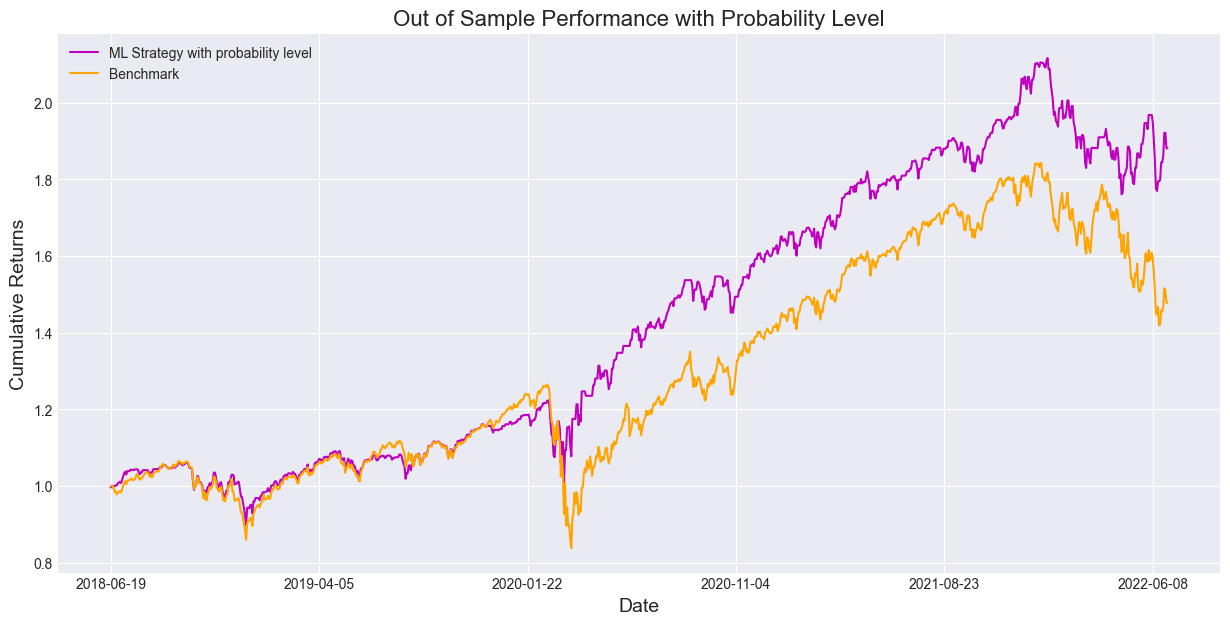

Benchmark SR: 0.55
Strategy SR: 0.95
Cumulative Returns after adding probability level: 1.88


In [7]:
# Calculate modified strategy returns
spy['strategy_returns_refined'] = spy.Close.pct_change() * \
    spy.predicted_signal_refined.shift(1)

# Store the test data in the dataframe
test_data = spy.iloc[split:]

# Calculate and plot the cumulative returns of the modified strategy
(test_data['strategy_returns_refined']+1).cumprod().plot(
    label='ML Strategy with probability level', figsize=(15, 7), color='m')

# Calculate and plot the cumulative returns of the benchmark in the same time period
(test_data.Close.pct_change()+1).cumprod().plot(label='Benchmark', color = 'orange')
# Set title
plt.title('Out of Sample Performance with Probability Level', fontsize=16)
# Set x and y axis labels
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend()
plt.show()

# Create a function to calculate sharpe ratio
def get_sr(ret):
    return round(ret.mean()/ret.std()*252**0.5, 2)


# Print the Sharpe ratio of benchmark and strategy as well as the cumulative returns
print(f"Benchmark SR: {get_sr(test_data.Close.pct_change())}")
print(f"Strategy SR: {get_sr(test_data['strategy_returns_refined'])}")
print(f"Cumulative Returns after adding probability level: "'%.2f' %
      (test_data['strategy_returns_refined']+1).cumprod()[-1])

You see that both the strategy returns and Sharpe ratio is higher in comparison to the benchmark. On a closer look, you can see that the strategy managed not to decline as sharply as the index in March 2022 when the COVID-19 pandemic was declared.

Let's plot the cumulative returns of both strategies together.

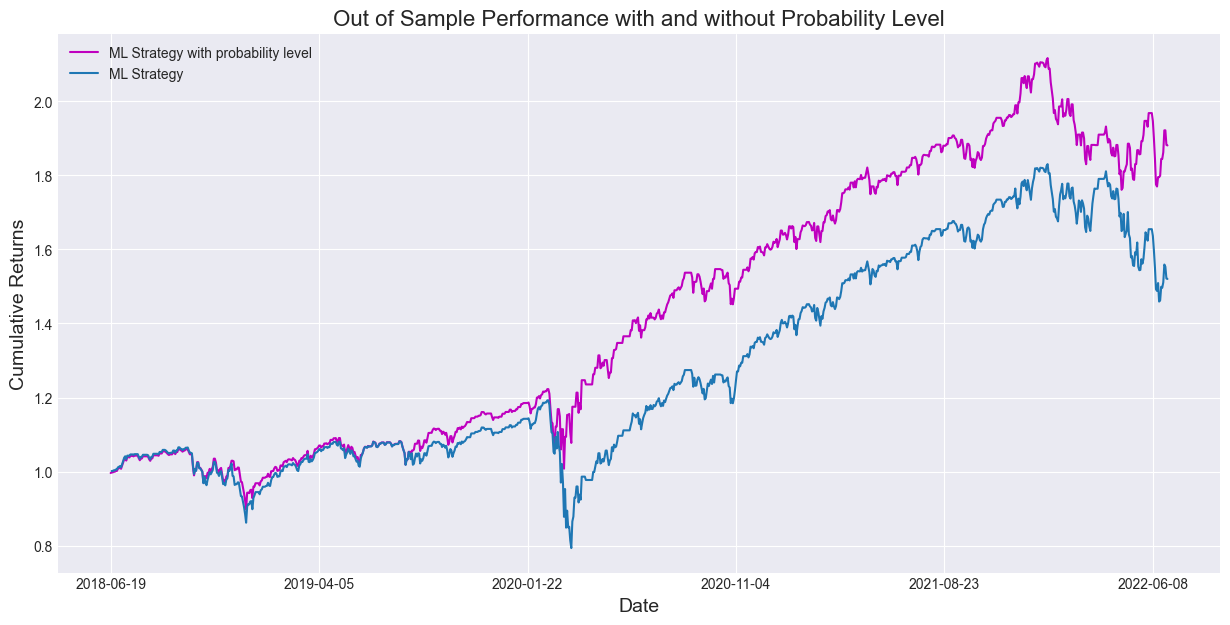

In [8]:
# Calculate and plot the cumulative returns of the modified strategy
(test_data['strategy_returns_refined']+1).cumprod().plot(
    label='ML Strategy with probability level', figsize=(15, 7), color='m')

# Calculate strategy returns of the strategy without probability levels
test_data['strategy_returns'] = test_data['Close'].pct_change() * test_data['predicted_signal'].shift(1)

# Calculate and plot the cumulative returns of the benchmark in the same time period
(test_data['strategy_returns'] +
 1).cumprod().plot(label='ML Strategy', figsize=(15, 7))

# Set title
plt.title('Out of Sample Performance with and without Probability Level', fontsize=16)

# Set x and y axis labels
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend()
plt.show()

You can see that the modified strategy with the probability level outperformed the strategy of the decision tree model without the probability level throughout the test data time period.

<a id='conclusion'></a>
## Conclusion

You have implemented the probability level on the strategy based on the decision tree machine learning model and observed that it leads to an increase in strategy performance. You have compared the modified strategy with probability levels to the benchmark as well and concluded that it outperformed the index. Note that this is not always the case and there might be times when adding a probability level might decrease the strategy's performance. In the next section, you will see other ways to improve the ML model.<br><br>
